In [1]:
import gc
import itertools
from functools import partial
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.linear_model
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.semi_supervised import LabelPropagation
import sklearn.multioutput
import tensorflow_text as text  # tf registers ops on import
import tensorflow as tf
from tensorflow.keras.regularizers import L2
import tensorflow_hub as hub
import transformers

from retrain_bert import settings
from retrain_bert.preprocessor import load_labels, get_labels_conf
from retrain_bert.utils import (ExactCategoryScore, make_targets)


2024-01-11 12:49:39.818600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 12:49:39.818632: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 12:49:39.818667: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 12:49:39.826875: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 12:49:40.785927: W tensorflow/compiler/

In [2]:
labels = load_labels(settings.DATA_DIR / "labels.csv")
train_data, val_data = train_test_split(pd.read_csv(settings.PROJECT_DIR / "data/train/train.csv").dropna(subset=["OcrValue"]), random_state=42)
labels = load_labels()
fuzzy_mappings = pd.read_csv(
        settings.PROJECT_DIR / "data/raw/Fuzzy_Mappings.csv",
        usecols=["OcrValue", "Correct_Desc"]
    ).dropna(subset=["Correct_Desc", "OcrValue"]
    ).drop_duplicates(subset=["OcrValue"])


In [3]:
fuzzy_validation = pd.merge(
    val_data,
    fuzzy_mappings,
    left_on="OcrValue",
    right_on="Correct_Desc",
    how="inner",
    suffixes=["_l", "_r"]
).drop(columns=["OcrValue_l", "Correct_Desc"]
).rename(columns={"OcrValue_r": "OcrValue"})

In [4]:
labels_conf = get_labels_conf(labels)

In [5]:
ecs = ExactCategoryScore(labels_conf)
exact_category_score = ecs.exact_category_score

In [6]:
val_targets = make_targets(val_data, labels_conf=labels_conf)

TypeError: make_targets() missing 1 required positional argument: 'labels_conf'

In [ ]:
custom_objects = {"KerasLayer": hub.KerasLayer}
with tf.keras.utils.custom_object_scope(custom_objects):
    old_model = tf.keras.models.load_model(settings.PROJECT_DIR / "models/bert_finetuned_2.h5")

old_val_preds = old_model.predict(val_data.OcrValue, batch_size=128)

2024-01-09 11:20:29.025957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 11:20:29.192396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 11:20:29.192753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

127/127 [==============================] - 144s 1s/step


In [ ]:
[round(exact_category_score(old_val_preds, val_targets, i), 3) for i in range(settings.DEEPEST_LEVEL)]

[0.935, 0.879, 0.786, 0.647, 0.647]

In [ ]:
category_matches_by_level = {
    level: exact_category(old_val_preds, val_targets, level)
    for level in range(settings.DEEPEST_LEVEL)
}
old_model_matches = pd.DataFrame(category_matches_by_level)
old_model_matches = np.concatenate([old_model_matches.values, val_data.values], axis=-1)
old_model_matches = pd.DataFrame(old_model_matches, columns=[f"level_{i}_match" for i in range(settings.DEEPEST_LEVEL)] + val_data.columns.tolist())
old_model_matches

,level_0_match,level_1_match,level_2_match,level_3_match,level_4_match,OcrValue,level_1,level_2,level_3,level_4,level_5
0,True,True,False,False,False,ESPRAI PROPOLIS,2,1,13,16,19
1,True,True,True,True,True,FREGONA ALG.CONSUM,2,0,6,5,19
2,True,False,False,False,False,BRIOCHE VEGETAL,1,1,21,33,19
3,True,True,True,True,True,TOMATE CHERRY 250G,1,5,1,2,19
4,True,True,True,True,True,IFA S/LACTOSA DESN [O],0,2,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
16234,True,True,True,True,True,COMBINADO APE,0,0,18,1,19
16235,True,True,True,True,True,ENJUAG.BUCAL S/ALCOH,2,1,4,1,19
16236,True,True,True,True,True,FILETE POLLO CONTR,1,0,4,0,2
16237,True,True,True,True,True,PATATAS FRITAS 260G,0,0,18,0,0


In [ ]:
def draw_matches_distribution(matches_df, suptitle=None):
    fig, axes = plt.subplots(ncols=settings.DEEPEST_LEVEL, figsize=(20, 4))

    legend_handles = None  # Variable to store legend handles

    for level in range(settings.DEEPEST_LEVEL):
        ax = axes[level]
        if "model" in matches_df.columns:
            scores = matches_df.groupby(["level_1", "model"])[f"level_{level}_match"].mean().reset_index()
            sns.barplot(data=scores, ax=ax, x=scores["level_1"] + 1, y=f"level_{level}_match", hue="model", hue_order=["old", "new", "new_cleaned"])
        else:
            scores = matches_df.groupby("level_1")[f"level_{level}_match"].mean()
            sns.barplot(data=scores, ax=ax)

        if legend_handles is None:
            legend_handles, _ = ax.get_legend_handles_labels()

        ax.set(ylim=(0, 1), ylabel=f"Accuracy up to level {level + 1}", xlabel="Level 1 category")
        ax.set_title(f"First {level + 1} levels correct")

    for ax in axes:
        ax.legend().remove()

    # Apply the legend to the entire figure
    if legend_handles:
        fig.legend(handles=legend_handles, loc='upper left')

    if suptitle:
        plt.suptitle(suptitle)

    plt.tight_layout()

In [ ]:
fuzzy_val_sample = fuzzy_validation.sample(10000, random_state=42)
fuzzy_val_targets = make_targets(fuzzy_val_sample)
old_fuzzy_val_preds = old_model.predict(fuzzy_val_sample.OcrValue, batch_size=128)

79/79 [==============================] - 86s 1s/step


In [ ]:
def get_matches_df(preds, data, targets):
    category_matches_by_level = {
    level: exact_category(preds, targets, level)
        for level in range(settings.DEEPEST_LEVEL)
    }
    matches = pd.DataFrame(category_matches_by_level)
    matches = np.concatenate([matches.values, data.values], axis=-1)
    matches = pd.DataFrame(matches, columns=[f"level_{i}_match" for i in range(settings.DEEPEST_LEVEL)] + data.columns.tolist())
    return matches

In [ ]:
old_model_fuzzy_matches = get_matches_df(old_fuzzy_val_preds, fuzzy_val_sample, fuzzy_val_targets)
old_model_fuzzy_matches

,level_0_match,level_1_match,level_2_match,level_3_match,level_4_match,level_1,level_2,level_3,level_4,level_5,OcrValue
0,True,False,False,False,False,0,3,1,0,1,COCA CLA LIGHT X2 P59
1,True,False,False,False,False,0,0,14,4,19,GNOCCHI CE PATATA
2,False,False,False,False,False,2,0,10,2,0,PURIO/BDLSAS DE BÅSURA
3,True,True,True,False,False,0,0,3,3,0,BARRI TAS CHOCOLATE 3N35
4,False,False,False,False,False,1,5,1,5,0,"0,438 ZANAHORIA 0,85"
...,...,...,...,...,...,...,...,...,...,...,...
9995,True,True,True,True,True,1,0,4,0,19,1ALAS DE POLLO
9996,True,True,True,True,True,0,0,3,0,3,CHOC NCGRO 72X
9997,True,True,True,True,True,1,6,1,8,19,MASA HOJALDRE 230 G P32 5M00
9998,True,True,False,False,False,1,1,7,33,19,EMPANADA TONYINA EL


In [ ]:
del old_model

In [ ]:
import unidecode
def clean_ocrs(ocrs: pd.Series):
    ocrs = ocrs.str.replace(r"\s+", " ")
    ocrs = ocrs.str.strip()
    ocrs = ocrs.str.lower()
    ocrs = ocrs.apply(unidecode.unidecode)
    return ocrs

clean_fuzzy_val_sample = fuzzy_val_sample.copy()
clean_fuzzy_val_sample["OcrValue"] = clean_ocrs(clean_fuzzy_val_sample.OcrValue)

In [ ]:
with tf.keras.utils.custom_object_scope(custom_objects):
    new_model = tf.keras.models.load_model(settings.PROJECT_DIR / "models/bert_finetuned.keras")

new_val_preds = new_model.predict(val_data.OcrValue, batch_size=128)
new_fuzzy_val_preds = new_model.predict(fuzzy_val_sample.OcrValue, batch_size=128)
clean_fuzzy_preds = new_model.predict(clean_fuzzy_val_sample.OcrValue, batch_size=128)

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


79/79 [==============================] - 85s 1s/step


In [ ]:
new_val_matches = get_matches_df(new_val_preds, val_data, val_targets)
new_fuzzy_val_matches = get_matches_df(new_fuzzy_val_preds, fuzzy_val_sample, fuzzy_val_targets)
cleaned_fuzzy_matches = get_matches_df(clean_fuzzy_preds, clean_fuzzy_val_sample, fuzzy_val_targets)

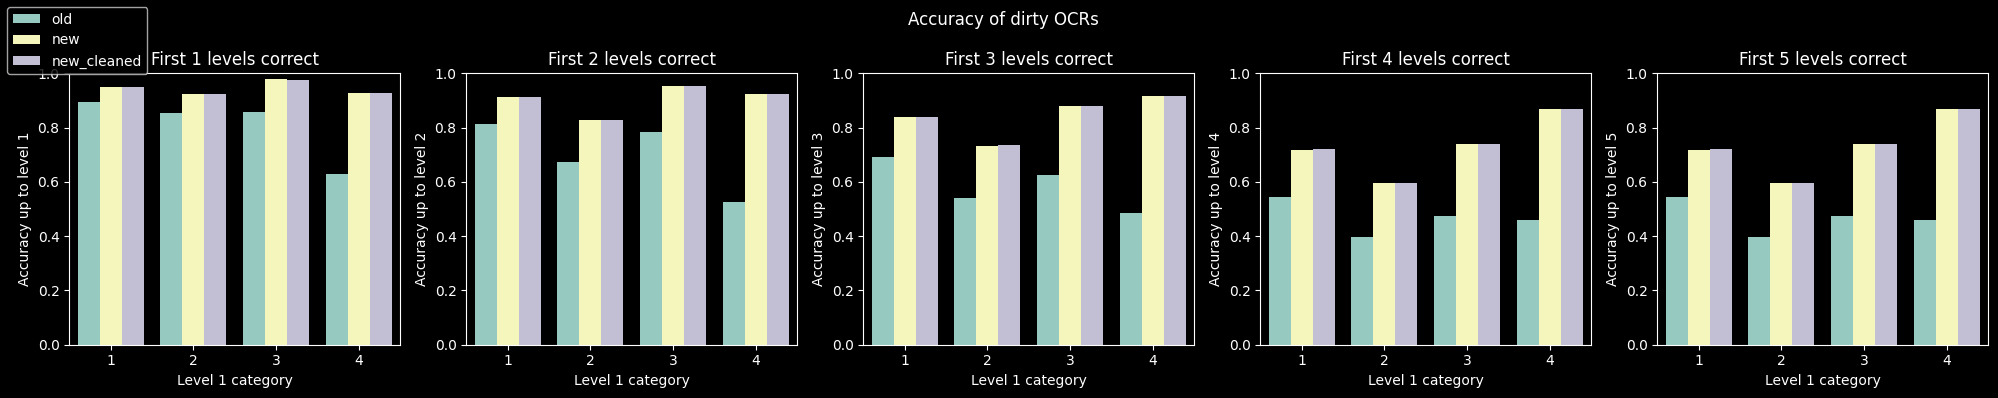

In [ ]:
old_model_fuzzy_matches["model"] = "old"
new_fuzzy_val_matches["model"] = "new"
cleaned_fuzzy_matches["model"] = "new_cleaned"
fuzzy_val_matches = pd.concat([old_model_fuzzy_matches, new_fuzzy_val_matches, cleaned_fuzzy_matches])

draw_matches_distribution(fuzzy_val_matches, "Accuracy of dirty OCRs")

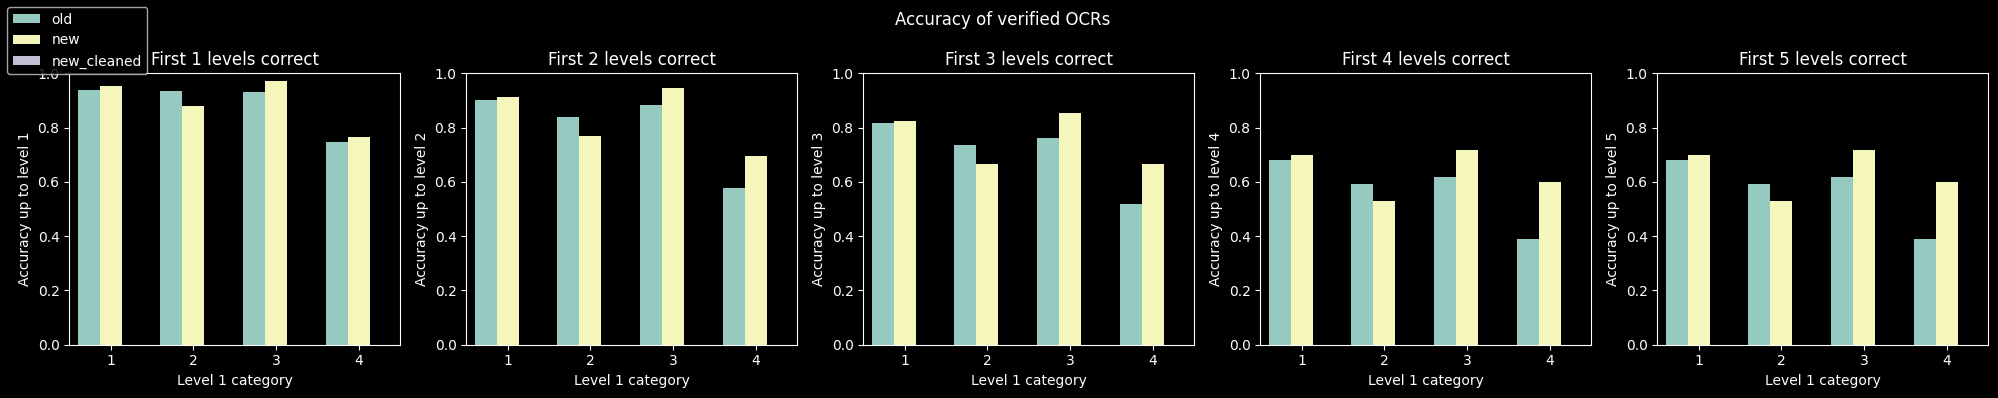

In [ ]:
old_model_matches["model"] = "old"
new_val_matches["model"] = "new"
val_matches = pd.concat([old_model_matches, new_val_matches])

draw_matches_distribution(val_matches, "Accuracy of verified OCRs")

In [ ]:
def precision_recall_tradeoff(y_true, y_pred, threshold):
    precisions = []
    recalls = []

    correct_so_far = np.ones((y_true[0].shape[0], 1), dtype=bool)

    for level in range(settings.DEEPEST_LEVEL):
        y_true_level = y_true[level].astype(bool)
        y_pred_level = y_pred[level]


        y_true_label = np.argmax(y_true_level, axis=1)
        y_pred_label = np.argmax(y_pred_level, axis=1)

        correct_so_far &= (y_true_label == y_pred_label).reshape(-1, 1)
        true_positives = (y_pred_level > threshold) & y_true_level & correct_so_far
        previous_wrong = (y_pred_level > threshold) & y_true_level & (~correct_so_far)
        false_positives = (y_pred_level > threshold) & (~y_true_level)
        false_negatives = (y_pred_level <= threshold) & y_true_level

        precisions.append(true_positives.sum(axis=0) / (true_positives.sum(axis=0) + false_positives.sum(axis=0) + previous_wrong.sum(axis=0) + 1e-6))
        recalls.append(true_positives.sum(axis=0) / (true_positives.sum(axis=0) + false_negatives.sum(axis=0) + previous_wrong.sum(axis=0) + 1e-6))

    return precisions, recalls

In [ ]:
precisions = {}
recalls = {}

for threshold in np.linspace(0, 1, 100):
    precisions[threshold], recalls[threshold] = precision_recall_tradeoff(fuzzy_val_targets, new_fuzzy_val_preds, threshold)

In [ ]:
def get_score_df(precisions, recalls, level):
    precision_scores = {k: v[level][:-1].mean() for k, v in precisions.items()}
    recall_scores = {k: v[level][:-1].mean() for k, v in recalls.items()}
    df = pd.DataFrame({"precision": precision_scores, "recall": recall_scores})
    df["f1"] = 2 * df["precision"] * df["recall"] / (df["precision"] + df["recall"])
    df.index.name = "threshold"
    df.reset_index(inplace=True)
    return df

In [ ]:
def draw_scores(scores_df):
    scores_df = scores_df.melt(id_vars=["threshold"], value_vars=["precision", "recall", "f1"], var_name="metric", value_name="score")
    ax = sns.lineplot(data=scores_df, x="threshold", hue="metric", y="score")
    ax.set(ylim=(0, 1))
    plt.show()

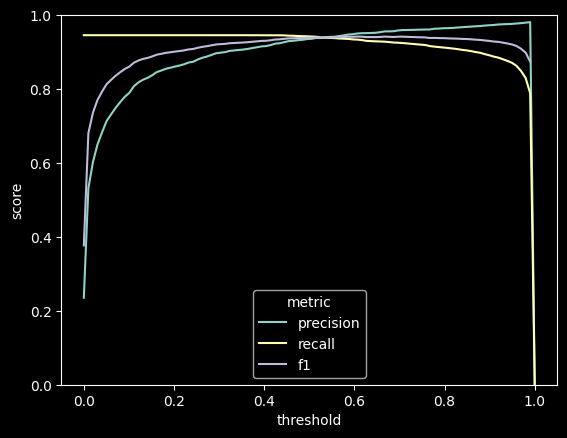

In [ ]:
level_1_df = get_score_df(precisions, recalls, 0)
draw_scores(level_1_df)

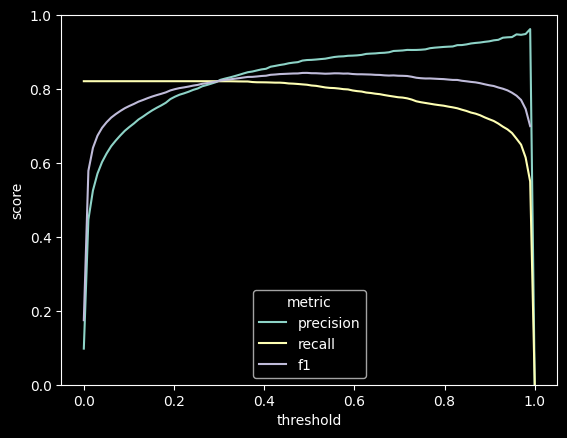

In [ ]:
level_2_df = get_score_df(precisions, recalls, 1)
draw_scores(level_2_df)

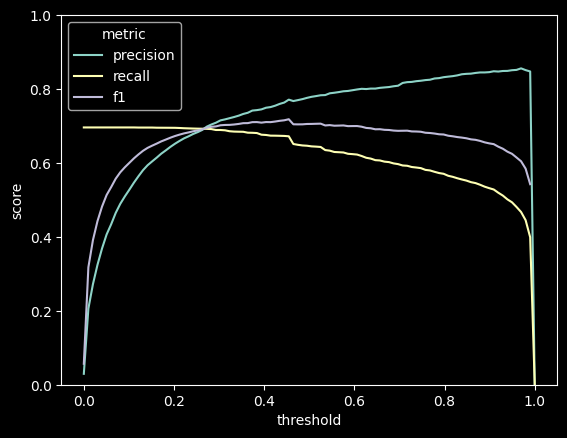

In [ ]:
level_3_df = get_score_df(precisions, recalls, 2)
draw_scores(level_3_df)

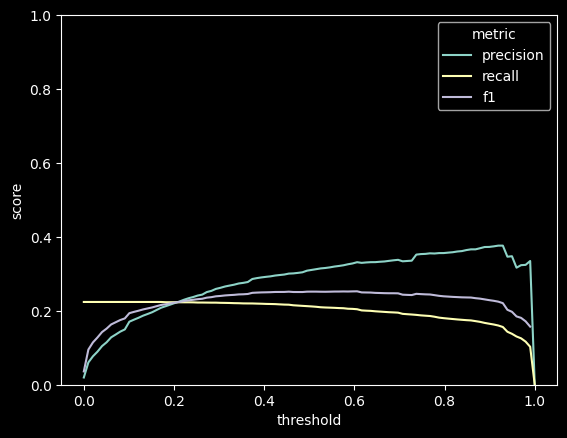

In [ ]:
level_4_df = get_score_df(precisions, recalls, 3)
draw_scores(level_4_df)

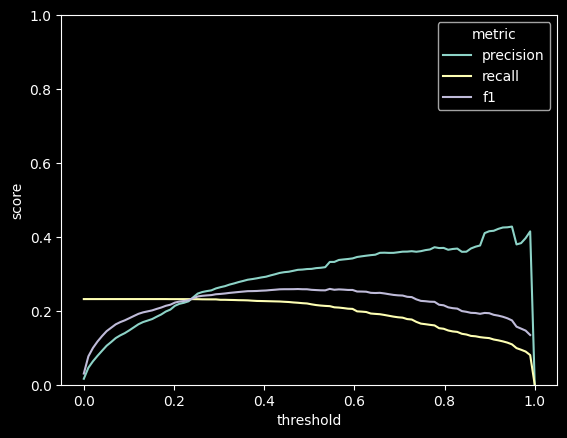

In [ ]:
level_5_df = get_score_df(precisions, recalls, 4)
draw_scores(level_5_df)

## Model calibration

In [ ]:
new_fuzzy_val_matches

,level_0_match,level_1_match,level_2_match,level_3_match,level_4_match,level_1,level_2,level_3,level_4,level_5,OcrValue,model
0,True,True,True,True,True,0,3,1,0,1,COCA CLA LIGHT X2 P59,new
1,False,False,False,False,False,0,0,14,4,19,GNOCCHI CE PATATA,new
2,True,True,True,True,True,2,0,10,2,0,PURIO/BDLSAS DE BÅSURA,new
3,True,True,False,False,False,0,0,3,3,0,BARRI TAS CHOCOLATE 3N35,new
4,True,True,True,True,True,1,5,1,5,0,"0,438 ZANAHORIA 0,85",new
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,True,True,True,True,1,0,4,0,19,1ALAS DE POLLO,new
9996,True,True,True,True,True,0,0,3,0,3,CHOC NCGRO 72X,new
9997,True,True,True,True,True,1,6,1,8,19,MASA HOJALDRE 230 G P32 5M00,new
9998,True,True,False,False,False,1,1,7,33,19,EMPANADA TONYINA EL,new


In [ ]:
new_fuzzy_val_probabilities = np.array([np.max(p, axis=1) for p in new_fuzzy_val_preds]).T
new_fuzzy_val_pred_classes = np.array([np.argmax(p, axis=1) for p in new_fuzzy_val_preds]).T
new_fuzzy_val_cumulative_probabilities = np.cumprod(new_fuzzy_val_probabilities, axis=1)

In [ ]:
new_fuzzy_val_probabilities

array([[0.9436247 , 0.9992718 , 0.99603623, 0.99777704, 0.96403575],
       [0.6672197 , 0.4707815 , 0.19379835, 0.47252873, 0.92622125],
       [0.9999962 , 0.99990666, 0.999995  , 0.9999862 , 0.95474553],
       ...,
       [0.99743146, 0.9903217 , 0.98802906, 0.88697505, 0.9729014 ],
       [0.7327106 , 0.39043972, 0.35049656, 0.22079124, 0.9314264 ],
       [0.9995158 , 0.9952657 , 0.99610573, 0.9973712 , 0.9993717 ]],
      dtype=float32)

In [ ]:
new_fuzzy_val_cumulative_probabilities = pd.DataFrame(new_fuzzy_val_cumulative_probabilities, columns=[f"level_{i}_cumulative_probability" for i in range(settings.DEEPEST_LEVEL)])
new_fuzzy_val_matches_with_probs = pd.concat([new_fuzzy_val_matches, new_fuzzy_val_cumulative_probabilities], axis=1)

In [ ]:
new_fuzzy_val_matches_with_probs[["level_0_match", "level_0_cumulative_probability"]]

,level_0_match,level_0_cumulative_probability
0,True,0.943625
1,False,0.667220
2,True,0.999996
3,True,0.984886
4,True,0.999499
...,...,...
9995,True,0.993955
9996,True,0.996845
9997,True,0.997431
9998,True,0.732711


In [ ]:
new_fuzzy_val_probabilities[:, 0]

array([0.9436247 , 0.6672197 , 0.9999962 , ..., 0.99743146, 0.7327106 ,
       0.9995158 ], dtype=float32)

In [ ]:
bins = np.linspace(0, 1, 10)

In [ ]:
def get_bins(df, level, num_bins=20):
    bins = np.linspace(0, 1, num_bins)
    binned = np.digitize(df[f"level_{level}_cumulative_probability"], bins)
    calibration = df.groupby(binned)[f"level_{level}_match"].mean().reset_index()
    calibration.columns = ["bin", "accuracy"]
    calibration["bin"] = bins[calibration["bin"] - 1]
    return calibration

def draw_calibration_plot(calibration, ax, level):
    sns.scatterplot(data=calibration, x="bin", y="accuracy", ax=ax)
    ax.set(xlim=(0, 1), ylim=(0, 1), xlabel="Predicted probability", ylabel="Accuracy")
    ax.plot([0, 1], [0, 1], color="red", linestyle="--")
    ax.set_title(f"Calibration plot for level {level + 1}")

In [ ]:
binned = np.digitize(new_fuzzy_val_probabilities[:, 0], bins)
level_0_calibration = new_fuzzy_val_matches_with_probs[["level_0_match"]].groupby(binned).mean().reset_index()
level_0_calibration.columns = ["bin", "accuracy"]
level_0_calibration["bin"] = bins[level_0_calibration["bin"] - 1]

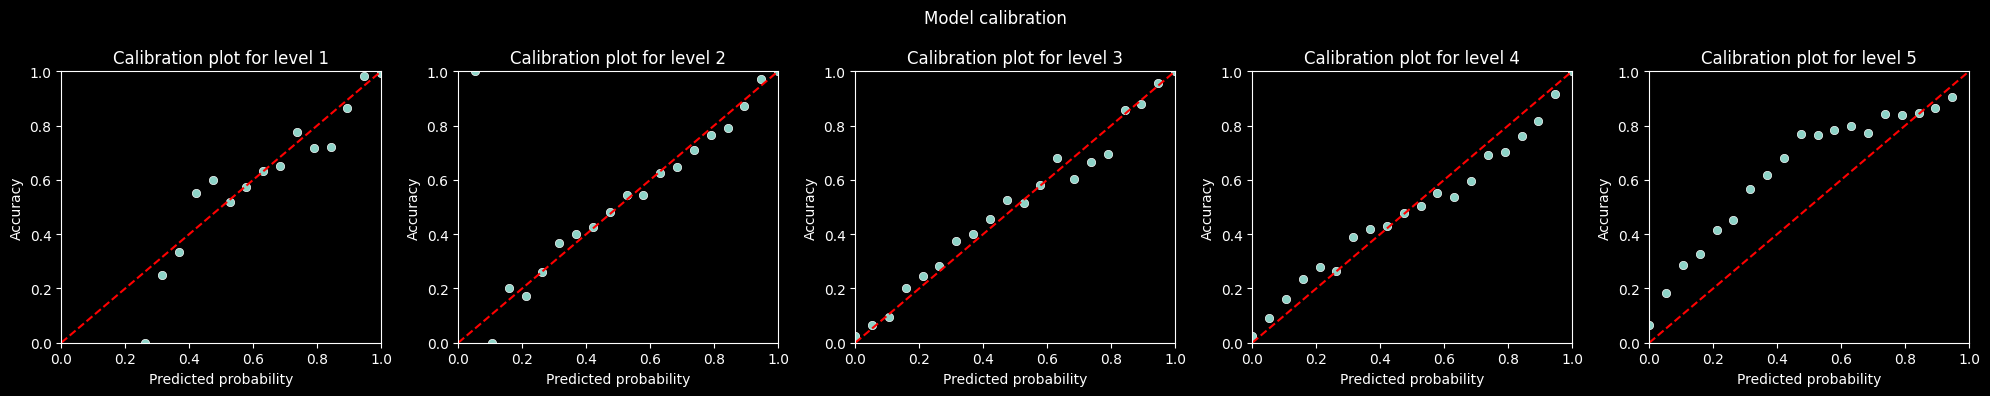

In [ ]:
fig, axes = plt.subplots(ncols=settings.DEEPEST_LEVEL, figsize=(20, 4))

for ax, level in zip(axes, range(settings.DEEPEST_LEVEL)):
    calibration = get_bins(new_fuzzy_val_matches_with_probs, level)
    draw_calibration_plot(calibration, ax, level)

plt.suptitle("Model calibration")
plt.tight_layout()
plt.show()
